In [1]:
from graphviz import Digraph
import math

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
class Value:
    #Unlike Torch Autograd which works with Vector Micrograd Value Class Takes Scaler Values
    def __init__(self,data,_children=(),_op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self._backward = lambda : None
        self.label = ''
    
    def __repr__(self):
        #return (f"Value is {self.data}, grad is {self.grad}")
        return (f"Value(data={self.data})")
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only Supporting INT/FLOAT for now"
        out = Value(self.data**other,(self,),f"**{other}")
        
        def _backward():
            self.grad += other*(self.data**other-1)*out.grad
            
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1) 
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
            
        out._backward = _backward
        return out
        
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    
    
    def __neg__(self): #-self
        return -1*self
    
    def __radd__(self,other): #1 + a
        return self+other
    
    def __rmul__(self,other): #1 * a
        return self*other
    
    def __sub__(self,other):  # a-b = a+__neg__(b)
        return self+(-other)
    
    def __truediv__(self,other): # a / b
        return self*other**-1
    
    def __rtruediv__(self,other): # other / self
        return other*self**-1
    
    

In [4]:
a = Value(0.5);a.label="a"
b = Value(0.77);b.label="b"
c = a+b;c.label="c"
print(c)

Value(data=1.27)


In [5]:
d = c*a;d.label = "d"
d
d.label

'd'

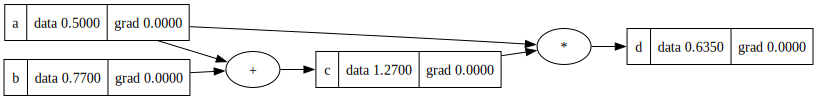

In [6]:
draw_dot(d)

In [7]:
e = c.tanh();e.label='e'
e

Value(data=0.8537976531552436)

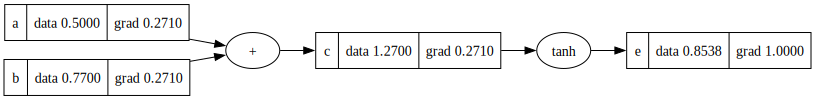

In [8]:
e.backward()
draw_dot(e)

In [9]:
e

Value(data=0.8537976531552436)

In [10]:
import random

In [11]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for xi,wi in zip(x,self.w)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            pms = neuron.parameters()
            params.extend(pms)
        return params
    
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [61]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)


Value(data=-0.68692470452849)

In [66]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]
     ] #Input Vector
ys = [1.0,-1.0,-1.0,1.0] #Desired Output
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9944661071845466),
 Value(data=0.12026000699018644),
 Value(data=0.16794293379644518),
 Value(data=-0.9940706606438445)]

In [70]:
for i in range(20):
    #Forward Pass and Loss Calculation
    ypred = [n(x) for x in xs]
    loss = sum((yp-yact)**2 for yp,yact in zip(ypred,ys))
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05*p.grad
    
    print(i,loss.data)
    

0 10.291165150853494
1 9.64788922417268
2 10.282353268004474
3 9.65910282257182
4 10.274406471740754
5 9.669252428106136
6 10.26723522914038
7 9.6784538415694
8 10.260754811362219
9 9.686813951556227
10 10.254885954926479
11 9.69443075327901
12 10.249555225371473
13 9.701393546221219
14 10.244695169842
15 9.70778324348413
16 10.240244322033611
17 9.713672747234611
18 10.236147104410355
19 9.71912736089194


In [68]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9965185907158568),
 Value(data=0.07845746513187048),
 Value(data=0.1450852249973347),
 Value(data=-0.99628943225123)]